# BitNet

https://arxiv.org/pdf/2310.11453

What's the simplest network we could train using a regular Linear layer, so that we have a baseline to compare a BitLinear layer?

In [70]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Dataset

Let's work with MNIST. It's quick, easy, and real-world enough that the results matter.

In [71]:
mnist = datasets.MNIST("~/.data", transform=transforms.Compose([transforms.PILToTensor(), transforms.ToDtype(torch.float32, scale=True)]))
mnist_dl = DataLoader(mnist, batch_size=600) # 100 batches

### Linear layer model

Let's use a simple Linear layer to get a baseline. Then, we'll replace the Linear layer with a BitLinear layer and compare.

In [72]:
class Round(nn.Module):
    def __init__(self, ste=True):
        super().__init__()
        self.ste = ste
        
    def forward(self, x):
        if self.ste:
            xf = x
            xb = torch.round(x)
            return xf + (xb - xf).detach()
        else:
            return torch.round(x)

In [73]:
class MyModel(nn.Module):
    def __init__(self, ste=True): 
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_1 = nn.Linear(784, 128)
        self.round = Round(ste=ste)
        self.linear_2 = nn.Linear(128, 10)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_1(x)
        x = self.round(x)
        x = self.linear_2(x)
        x = self.log_softmax(x)
        return x

In [74]:
def train(model, dl, lr=0.001):
    it = iter(dl)
    losses = []
    for xs, ys in tqdm(it, total=100):
        ps = model(xs)
        loss = -torch.gather(ps, 1, ys.unsqueeze(1)).mean()
        losses.append(loss.detach())
        loss.backward()
        with torch.no_grad():
            for p in model.parameters():
                p -= p.grad * lr
    return model, losses

## No STE

In [75]:
model = MyModel(ste=False)

In [76]:
model, losses = train(model, mnist_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

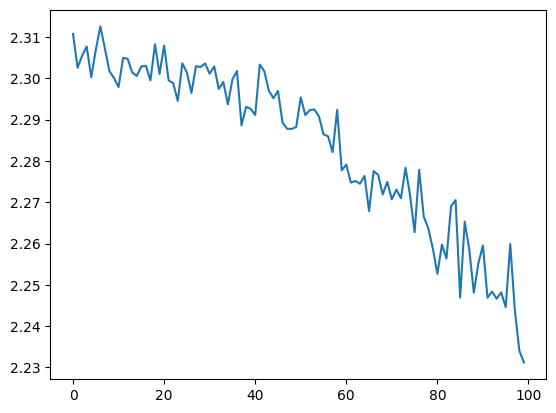

In [77]:
plt.plot(range(100), losses)

## Yes STE

In [79]:
model = MyModel(ste=True)

In [80]:
model, losses = train(model, mnist_dl)

  0%|          | 0/100 [00:00<?, ?it/s]

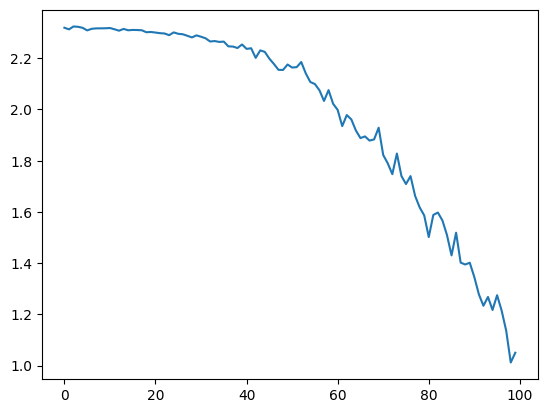

In [81]:
plt.plot(range(100), losses)

In [68]:
# Gradient of `torch.round` exists. `backward()` doesn't raise an exception. Torch just treats the gradient as zero.
a = torch.tensor(1.5)
a.requires_grad_()
b = torch.round(a)
b.backward()
print(b.grad_fn, a.grad)

<RoundBackward0 object at 0x7d91a81c80a0> tensor(0.)
